In [73]:
import os

In [74]:
%pwd

'C:\\Users\\anand\\Desktop\\reume_projet\\AutoPrice-AI'

In [75]:
os.chdir("../")

In [76]:
%pwd

'C:\\Users\\anand\\Desktop\\reume_projet'

In [77]:
os.chdir("C:/Users/anand/Desktop/reume_projet/AutoPrice-AI")

In [78]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Any



@dataclass(frozen=True)
class ModelTrainerConfig:
    root_dir: Path
    train_data_path: Path
    test_data_path: Path
    model_name: str
    target_column: str
    params:Dict[str, Any] 

In [79]:
from mlProject.constants import *
from mlProject.utils.common import read_yaml, create_directories

In [80]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])


    def get_model_trainer_config(self) -> ModelTrainerConfig:
        config = self.config.model_trainer
        params = self.params.Xgboost
        schema =  self.schema.TARGET_COLUMN

        create_directories([config.root_dir])

        model_trainer_config = ModelTrainerConfig(
            root_dir=config.root_dir,
            train_data_path = config.train_data_path,
            test_data_path = config.test_data_path,
            model_name = config.model_name,
            params= params,
            target_column = schema.name
            
        )

        return model_trainer_config

In [81]:
from dataclasses import dataclass
from pathlib import Path
import os
import joblib
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from typing import Dict, Any, Tuple
import json
import yaml

In [82]:
import os
from mlProject import logger
from mlProject.entity.config_entity import ModelTrainerConfig
import pandas as pd
from xgboost import XGBRegressor
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance

class ModelTrainer:
    def __init__(self, config: ConfigurationManager):
        self.config = config

    def train(self):
        # Load data
        train_data = pd.read_csv(self.config.train_data_path)
        test_data = pd.read_csv(self.config.test_data_path)

        train_x = train_data.drop([self.config.target_column], axis=1)
        test_x = test_data.drop([self.config.target_column], axis=1)
        train_y = train_data[self.config.target_column]
        test_y = test_data[self.config.target_column]

        # Define hyperparameter grid
        param_grid = {
            'n_estimators': [100,200, 300, 400, 500 ,600],
            'max_depth': [3, 4, 6, 8,7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.7, 0.8, 1.0],
            'colsample_bytree': [0.7, 0.8, 1.0],
            'gamma': [0, 1, 5],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [1, 5, 10]
        }

        base_model = XGBRegressor(
            random_state=42,
            n_jobs=-1,
            verbosity=0,
            objective='reg:squarederror'
        )

        search = RandomizedSearchCV(
            base_model,
            param_distributions=param_grid,
            n_iter=25,
            scoring='r2',
            cv=5,
            verbose=1,
            n_jobs=-1
        )

        # Fit the randomized search model
        search.fit(train_x, train_y)

        best_model = search.best_estimator_

        # Optionally evaluate on test set
        preds = best_model.predict(test_x)
        r2 = r2_score(test_y, preds)
        logger.info(f"Test R² Score: {r2}")

        # Save the best model
        model_path = os.path.join(self.config.root_dir, self.config.model_name)
        joblib.dump(best_model, model_path)

        logger.info(f"Best model saved to {model_path}")

        sns.scatterplot(x=test_y, y=preds)
        plt.xlabel("Actual Price")
        plt.ylabel("Predicted Price")
        plt.title("Actual vs Predicted")
        plt.show()

        plot_importance(best_model)
        plt.show()


[2025-06-18 02:54:38,189: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-06-18 02:54:38,194: INFO: common: yaml file: params.yaml loaded successfully]
[2025-06-18 02:54:38,197: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-06-18 02:54:38,198: INFO: common: created directory at: artifacts]
[2025-06-18 02:54:38,199: INFO: common: created directory at: artifacts/model_trainer]
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[2025-06-18 02:54:42,077: INFO: 2801709636: Test R² Score: 0.5534208034844705]
[2025-06-18 02:54:42,096: INFO: 2801709636: Best model saved to artifacts/model_trainer\model.joblib]


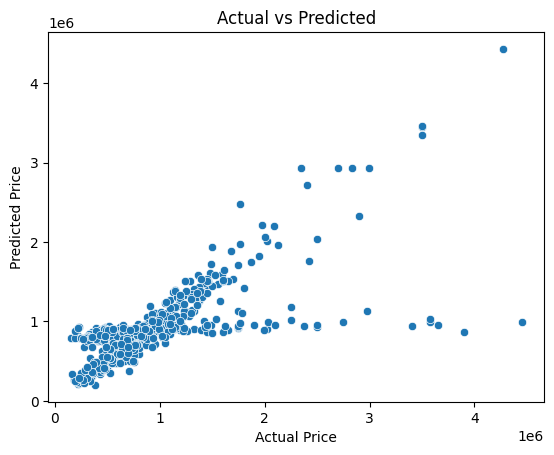

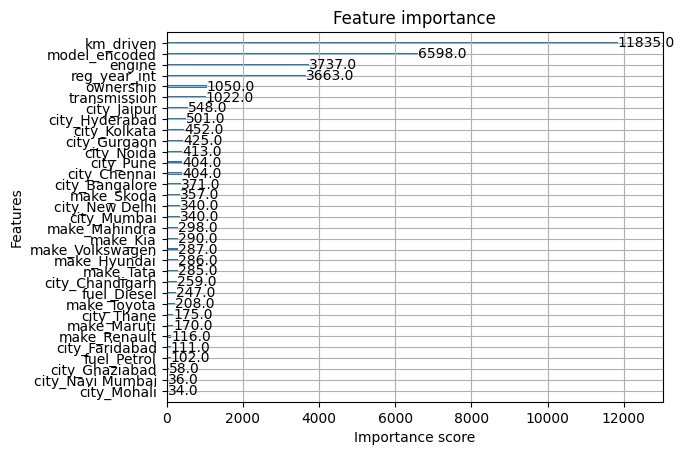

In [83]:
try:
    config = ConfigurationManager()
    model_trainer_config = config.get_model_trainer_config()
    model_trainer_config = ModelTrainer(config=model_trainer_config)
    model_trainer_config.train()
except Exception as e:
    raise e

NameError: name 'test_y' is not defined